ФИО: Мушенко Егор Сергеевич

In [1]:
import os
print(os.environ.get('PYTORCH_CUDA_ALLOC_CONF'))

#os.system('chcp 65001')

None


In [2]:
%cd /kaggle/working
#%cp /kaggle/input/labor6/* /kaggle/working
%ls -al

/kaggle/working
total 16
drwxr-xr-x 3 root root 4096 Apr 20 13:20 ./
drwxr-xr-x 5 root root 4096 Apr 20 13:20 ../
drwxr-xr-x 2 root root 4096 Apr 20 13:20 .virtual_documents/
---------- 1 root root  263 Apr 20 13:20 __notebook_source__.ipynb


In [3]:
!ls -al ../input/labor6

total 153312
drwxr-xr-x 2 nobody nogroup         0 Apr 19 15:12 .
drwxr-xr-x 3 root   root         4096 Apr 20 13:20 ..
-rw-r--r-- 1 nobody nogroup 152186737 Apr 19 15:12 FIXED_coco_resnet_50_map_0_335_state_dict.pt
-rw-r--r-- 1 nobody nogroup      6447 Apr 19 15:12 coco_eval.py
-rw-r--r-- 1 nobody nogroup      1332 Apr 19 15:12 coco_id_to_name.json
-rw-r--r-- 1 nobody nogroup      8893 Apr 19 15:12 coco_utils.py
-rw-r--r-- 1 nobody nogroup      1831 Apr 19 15:12 dataset.py
-rw-r--r-- 1 nobody nogroup      4264 Apr 19 15:12 engine.py
-rw-r--r-- 1 nobody nogroup    287430 Apr 19 15:12 oi5_ball_filename_to_bbox_train.json
-rw-r--r-- 1 nobody nogroup       114 Apr 19 15:12 requirements.txt
-rw-r--r-- 1 nobody nogroup     23337 Apr 19 15:12 transforms.py
-rw-r--r-- 1 nobody nogroup      8388 Apr 19 15:12 utils.py
-rw-r--r-- 1 nobody nogroup      1046 Apr 19 15:12 visualization.py
-rw-r--r-- 1 nobody nogroup   4426094 Apr 19 15:12 workshop_completed.ipynb


In [4]:
import requests
from urllib.parse import urlencode

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/D-q6ahy6j8Jfow'  


final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']


download_response = requests.get(download_url)
with open('seminar_objdet_retina_oi5_ball.zip', 'wb') as f: 
    f.write(download_response.content)

In [5]:
!unzip -o -q seminar_objdet_retina_oi5_ball.zip

In [6]:
#!pip3 install torch torchvision torchaudio

In [7]:
#!pip3 install tensorflow-gpu

In [8]:
import torch

In [9]:
import json
import os
import random
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [10]:
!pip install opencv-python

In [11]:
import cv2
import random
import numpy as np
from PIL import Image
import albumentations as A
import torchvision.transforms as T
from imgaug import augmenters as iaa

class RandomBCAugmenter(object):
  def __call__(self, sample_image, mask):
    transform = A.Compose([A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, brightness_by_max=True, always_apply=False, p=0.5)]) 
    transformed = transform(image=sample_image)
    transformed_img = transformed["image"]
    return transformed_img, mask


class CV2Augmenter(object):
  def __call__(self, image, mask):
    height, width = image.shape[:2]
    quarter_height, quarter_width = height/4, width/4
    translation_matrix = np.float32([[1, 0, quarter_width],
                                     [0, 1, quarter_height]])
    transformed_img = cv2.warpAffine(image, translation_matrix, 
                                     (width, height))
    return transformed_img, mask


class TorchvisionAugmenter(object):
  def __call__(self, image, mask):
    transform = T.Compose([T.RandomCrop(size=320)])
    transformed_img = transform(image)
    return transformed_img, mask


class GaussianNoiseAugmenter(object):
  def __call__(self, image, mask):
    transform = iaa.Sequential([iaa.AdditiveLaplaceNoise(scale=(20, 70))])
    transformed_img = transform(image=image)
    return transformed_img, mask


class AffineAugmenter(object):
    def __init__(self, min_scale=0.9, max_offset=0.1, rotate=True):
        self._min_scale = min_scale
        self._max_offset = max_offset
        self._rotate = rotate

    def __call__(self, image, mask):
        image = np.array(image)  # PIL -> Numpy.
        mask = np.array(mask)
        h, w, c = image.shape
        assert c == 3
        if self._rotate:
            angle = random.random() * np.pi / 2 - np.pi / 4
        else:
            angle = 0
        scale = self._min_scale + random.random() * (1 - self._min_scale)
        rotation = cv2.getRotationMatrix2D(((w // 2), (h // 2)), angle * 180 / np.pi, scale)
        x_offset = random.randint(-int(self._max_offset * w), int(self._max_offset * w))
        y_offset = random.randint(-int(self._max_offset * h), int(self._max_offset * h))
        rotation[:, 2] += [x_offset, y_offset]
        new_image = cv2.warpAffine(image, rotation, (w, h), borderValue=(128, 128, 128))
        new_mask = cv2.warpAffine(mask, rotation, (w, h), borderValue=(0, 0, 0), flags=cv2.INTER_NEAREST)
        return new_image, new_mask  # Numpy -> PIL.


class BrightnessContrastAugmenter(object):
    def __init__(self, brightness=0.3, contrast=0.3):
        self._brightness = brightness
        self._contrast = contrast

    def __call__(self, image, mask):
        image = np.array(image)  # PIL -> Numpy.
        h, w, c = image.shape
        assert c == 3
        brightness = 2 * (random.random() - 0.5) * self._brightness
        contrast = 1 + 2 * (random.random() - 0.5) * self._contrast
        new_image = image.astype(np.float16)
        new_image += 255 * brightness
        new_image = (new_image - 128) * contrast + 128
        return new_image.clip(0, 255).astype(np.uint8), mask  # Numpy -> PIL.


class BlurAugmenter(object):
    def __init__(self, max_kernel=5):
        self._max_kernel = max_kernel

    def __call__(self, image, mask):
        kernel = random.randint(0, self._max_kernel // 2) * 2 + 1
        if kernel == 1:
            return image, mask
        image = np.array(image)  # PIL -> Numpy.
        h, w, c = image.shape
        assert c == 3
        new_image = cv2.GaussianBlur(image, (kernel, kernel), sigmaX=kernel / 2)
        return new_image.clip(0, 255).astype(np.uint8), mask  # Numpy -> PIL.

   
class FlipAugmenter(object):
    def __call__(self, image, mask):
        a = random.randint(0, 3)
        if a == 0:
            image = np.flip(image, axis=0)
            mask = np.flip(mask, axis=0)
        elif a == 1:
            image = np.flip(image, axis=0)
            mask = np.flip(mask, axis=0)
            image = np.flip(image, axis=1)
            mask = np.flip(mask, axis=1)
        elif a == 2:
            image = np.flip(image, axis=1)
            mask = np.flip(mask, axis=1)
        return image, mask


class RandomAugmentation(object):
    def __init__(self, *augmenters):
        self._augmenters = list(augmenters)

    def __call__(self, image, mask):
        augmenter = random.choice(self._augmenters)
        return augmenter(image, mask)

In [12]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import json


class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data_dict_file, transforms=None, add_path=None, augment=True):
        
        self.transforms = transforms
        with open(data_dict_file, 'r') as f:
            self.data_dict = json.load(f)
        if add_path:
            self.data_dict = {add_path                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       + i:j for i,j in self.data_dict.items()}

        self.imgs = list(self.data_dict.keys())  
        self._augmenter = RandomAugmentation(AffineAugmenter(),
                                             BrightnessContrastAugmenter(),
                                             BlurAugmenter(),
                                             FlipAugmenter(),                                            
                                             RandomBCAugmenter(),
                                             GaussianNoiseAugmenter())

    def __getitem__(self, idx, augment=True):
        img_path = self.imgs[idx]
        img = cv2.imread(img_path)
        if augment:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
            self._augmenter = RandomAugmentation(AffineAugmenter(),
                                                 BrightnessContrastAugmenter(),
                                                 BlurAugmenter(),
                                                 FlipAugmenter(),                                            
                                                 RandomBCAugmenter(),
                                                 GaussianNoiseAugmenter())
        else:
            self._augmenter = lambda image, mask: (image, mask)  

        img_res = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res /= 255.0
        width = img.shape[1]
        height = img.shape[0]
        boxes = []
        labels = []
        num_objs = len(self.data_dict[img_path]) 
        for i in range(num_objs):
            frame = self.data_dict[img_path][i]
            xmin = frame[0] * width
            xmax = frame[1] * width
            ymin = frame[2] * height
            ymax = frame[3] * height

            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms:
            sample = self.transforms(image = img_res,
                                     bboxes = target['boxes'],
                                     labels = labels)
            
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])

        return img_res, target

    def __len__(self):
        return len(self.imgs)

In [13]:
train_dataset = MyDataset(data_dict_file="oi5_ball_filename_to_bbox_train.json", 
                                 transforms=None, augment=True)#, add_path = 'labor6')

In [14]:
def plot_img_frame(img, frame):
    fig, a = plt.subplots(1,1)
    a.imshow(img)
    for box in (frame['boxes']):
        
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1] 
        
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r'
                                 , facecolor='none')

        a.add_patch(rect)
    plt.show()


In [15]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
      
def get_object_detection_model(num_classes):

    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

    return model

In [16]:
!pip install pycocotools --quiet
#!git clone https://github.com/pytorch/vision.git
#!git checkout v0.3.0



In [17]:
#!copy vision\references\detection\utils.py .
#!copy vision\references\detection\transforms.py .
#!copy vision\references\detection\coco_eval.py .
#!copy vision\references\detection\engine.py .
#!copy vision\references\detection\coco_utils.py .

In [18]:
!pip install --upgrade albumentations 

In [19]:
!cp ../input/labor6/*.py .

In [20]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [21]:
def get_transform(train):
    
    if train:
        return A.Compose([
                            A.HorizontalFlip(0.5),
                     # ToTensorV2 converts image to pytorch tensor without div by 255
                            ToTensorV2(p=1.0) 
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [22]:
dataset = MyDataset(data_dict_file="oi5_ball_filename_to_bbox_train.json", 
                                 transforms=get_transform(train=True), add_path = '')
dataset_test = MyDataset(data_dict_file="oi5_ball_filename_to_bbox_train.json", 
                                 transforms=get_transform(train=False), add_path = '')


torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=4, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=4, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [23]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


num_classes = 2

model = get_object_detection_model(num_classes)

model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [24]:
!pip install tqdm

In [25]:
import time
from tqdm import tqdm

In [26]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "0"

In [27]:
num_epochs = 3
#os.environ['max_split_size_mb'] = 100
 
for epoch in tqdm(range(num_epochs)):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    lr_scheduler.step()
    evaluate(model, data_loader_test, device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

<generator object MetricLogger.log_every at 0x7566d19d32d0>
Epoch: [0]  [  0/575]  eta: 0:59:13  lr: 0.000014  loss: 0.9947 (0.9947)  loss_classifier: 0.8285 (0.8285)  loss_box_reg: 0.1343 (0.1343)  loss_objectness: 0.0152 (0.0152)  loss_rpn_box_reg: 0.0167 (0.0167)  time: 6.1795  data: 0.9198  max mem: 4465
Epoch: [0]  [ 10/575]  eta: 0:11:45  lr: 0.000101  loss: 0.9034 (0.8939)  loss_classifier: 0.7212 (0.7193)  loss_box_reg: 0.1244 (0.1418)  loss_objectness: 0.0210 (0.0265)  loss_rpn_box_reg: 0.0035 (0.0062)  time: 1.2486  data: 0.1011  max mem: 7572
Epoch: [0]  [ 20/575]  eta: 0:09:16  lr: 0.000188  loss: 0.6643 (0.7268)  loss_classifier: 0.4859 (0.5295)  loss_box_reg: 0.1529 (0.1612)  loss_objectness: 0.0250 (0.0298)  loss_rpn_box_reg: 0.0036 (0.0062)  time: 0.7442  data: 0.0202  max mem: 7572
Epoch: [0]  [ 30/575]  eta: 0:08:29  lr: 0.000275  loss: 0.4261 (0.6165)  loss_classifier: 0.1876 (0.4160)  loss_box_reg: 0.1650 (0.1657)  loss_objectness: 0.0276 (0.0288)  loss_rpn_box_reg:

 33%|███▎      | 1/3 [08:44<17:29, 524.69s/it]

DONE (t=0.13s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.509
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.757
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.570
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.275
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.523
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.653
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.348
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.601
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.633
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.395
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.641
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.775
<genera

 67%|██████▋   | 2/3 [17:27<08:43, 523.30s/it]

DONE (t=0.08s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.501
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.747
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.546
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.269
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.524
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.638
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.351
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.586
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.605
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.356
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.616
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.752
<genera

100%|██████████| 3/3 [26:08<00:00, 522.92s/it]

DONE (t=0.08s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.512
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.768
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.560
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.254
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.530
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.668
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.363
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.602
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.621
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.377
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.622
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.774


In [28]:
img, target = dataset_test[55]
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

predicted #boxes:  3
real #boxes:  4


In [29]:
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

EXPECTED OUTPUT


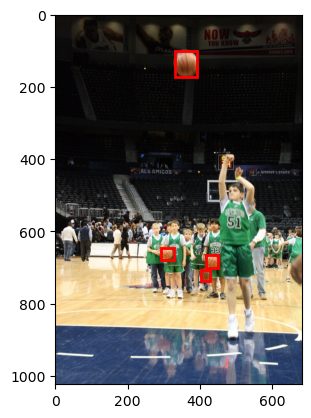

In [30]:
print('EXPECTED OUTPUT')
plot_img_frame(torch_to_pil(img), target)

In [31]:
prediction['boxes'] = prediction['boxes'].to('cpu')
prediction['labels'] = prediction['labels'].to('cpu')
prediction['scores'] = prediction['scores'].to('cpu')

MODEL OUTPUT


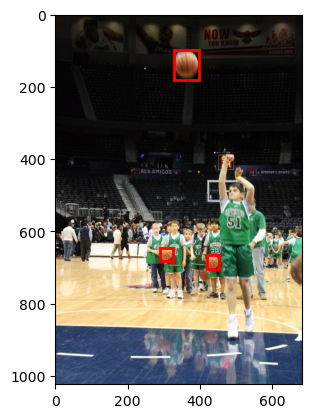

In [32]:
print('MODEL OUTPUT')
plot_img_frame(torch_to_pil(img), prediction)